# Plot qPCR of RNA loss due to filtering and clarifying supernatant

# Introduction

## Imports

In [1]:
import sys
import os
import time

import numpy as np
import scipy
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Set output parameters

In [2]:
# Set pandas display options
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Set plot display options
FONTSIZE = 8  # universal fontsize
params = {
    'font.size': FONTSIZE,
    'axes.titlesize': FONTSIZE,
    'axes.labelsize': FONTSIZE,
    'legend.fontsize': FONTSIZE,
    'xtick.labelsize': FONTSIZE,
    'ytick.labelsize': FONTSIZE,
    'font.family': "Helvetica",
    'mathtext.fontset': 'custom',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 300
   }
mpl.rcParams.update(params)
sns.set_style("ticks", {'axes.grid' : False})

# Set plot output options
output_dir = "outs/qPCR_clarify_filter"
output_suffix = ""
output_formats = [".png", ".pdf"]

mpl.rc('savefig', dpi=300)

# Define convenience function for saving figures

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.1}

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

In [3]:
# Report plot parameters
sns.plotting_context()

{'font.size': 8.0,
 'axes.labelsize': 8.0,
 'axes.titlesize': 8.0,
 'xtick.labelsize': 8.0,
 'ytick.labelsize': 8.0,
 'legend.fontsize': 8.0,
 'legend.title_fontsize': None,
 'axes.linewidth': 0.8,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.8,
 'ytick.major.width': 0.8,
 'xtick.minor.width': 0.6,
 'ytick.minor.width': 0.6,
 'xtick.major.size': 3.5,
 'ytick.major.size': 3.5,
 'xtick.minor.size': 2.0,
 'ytick.minor.size': 2.0}

# Load data

## Load qPCR data

In [4]:
infile = "../preprocessed_data/qPCR_data/qPCR_clarify_filter_Cq.csv"

cq_raw = pd.read_csv(infile, header=0)

print(cq_raw.shape)
cq_raw.head()

(20, 12)


,Well,Fluor,Target,Content,Sample,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev
0,A01,SYBR,mCherry,Unkn-01,95A-1,21.536833,21.466090,0.096997,29483.11823,4.469573,30959.91182,2046.388070
1,A02,SYBR,mCherry,Unkn-02,95A-2,21.188538,21.156946,0.097677,37241.78602,4.571030,38094.30808,2529.622920
2,A03,SYBR,mCherry,Unkn-03,95A-3,20.596654,20.612899,0.025250,55391.66533,4.743444,54796.61002,923.555799
3,A04,SYBR,mCherry,Unkn-04,95A-4,19.870191,19.957001,0.079550,90169.71613,4.955061,85150.54434,4579.413284
4,B01,SYBR,mCherry,Unkn-01,95A-1,21.505920,21.466090,0.096997,30100.80598,4.478578,30959.91182,2046.388070


# Preprocess data

## Calculate total starting molecules

In [5]:
# Calculate normalization for input volume
DILUTION_FACTORS = (300/140) * (42/20) * (61/10) * (20/1)

In [6]:
# Back-calculate input RNA molecules, given <100% efficiency of extraction, DNase, RT, as measured based on RNA standard

PROTOCOL_EFFICIENCY = 0.005957820738  # Efficiency of extraction, DNase, RT

In [7]:
# Calculate total RNA molecules in supernatant
cq_raw["RNA molecules"] = cq_raw["Starting Quantity (SQ)"] * DILUTION_FACTORS * (1/PROTOCOL_EFFICIENCY)
cq_raw["RNA molecules Mean"] = cq_raw["SQ Mean"] * DILUTION_FACTORS * (1/PROTOCOL_EFFICIENCY)
cq_raw["RNA molecules STD"] = cq_raw["SQ Std. Dev"] * DILUTION_FACTORS * (1/PROTOCOL_EFFICIENCY)

## Summarize replicates

In [8]:
groups = cq_raw.groupby(["Sample"])  # group samples by origin

summary = pd.DataFrame()

summary["mean SQ"] = groups["Starting Quantity (SQ)"].mean()  # Calculate mean over replicates
summary["std SQ"] = groups["Starting Quantity (SQ)"].std()  # Calculate mean over replicates

summary["RNA molecules"] = groups["RNA molecules"].mean()
summary["RNA molecules STD"] = groups["RNA molecules STD"].mean()

summary

,mean SQ,std SQ,RNA molecules,RNA molecules STD
Sample,,,,
95A-1,30959.911820,2046.388074,2.852887e+09,1.885701e+08
95A-2,38094.308073,2529.622920,3.510306e+09,2.330992e+08
95A-3,54796.610023,923.555799,5.049386e+09,8.510362e+07
95A-4,85150.544337,4579.413282,7.846434e+09,4.219828e+08
NTC,14.870735,12.949680,1.370305e+06,1.044124e+06


## Calculate relative abundance (compared to reference sample)

In [9]:
# Initialize columns

summary["RNA molecules relative to reference"] = np.nan
summary["RNA molecules relative to reference STD"] = np.nan

cq_raw["RNA molecules relative to reference"] = np.nan
cq_raw["RNA molecules relative to reference STD"] = np.nan

In [10]:
# Calculate RNA molecules relative to reference

# Gag-MCP

ref = summary.loc["95A-4", "RNA molecules"]  # set reference value
samples = ["95A-1", "95A-2", "95A-3", "95A-4"]  # samples that use this reference value

summary.loc[samples, "RNA molecules relative to reference"] = summary.loc[samples, "RNA molecules"] / ref
summary.loc[samples, "RNA molecules relative to reference STD"] = summary.loc[samples, "RNA molecules STD"] / ref

In [11]:
# Repeat for raw Cq values

cq_raw = cq_raw.set_index("Sample")

# Gag-MCP

ref = summary.loc["95A-4", "RNA molecules"]  # set reference value
samples = ["95A-1", "95A-2", "95A-3", "95A-4"]  # samples that use this reference value

cq_raw.loc[samples, "RNA molecules relative to reference"] = cq_raw.loc[samples, "RNA molecules"] / ref
cq_raw.loc[samples, "RNA molecules relative to reference STD"] = cq_raw.loc[samples, "RNA molecules STD"] / ref

cq_raw = cq_raw.reset_index()

In [12]:
# Convert to percentage

summary["RNA molecules relative to reference %"] = summary["RNA molecules relative to reference"] * 100
summary["RNA molecules relative to reference STD %"] = summary["RNA molecules relative to reference STD"] * 100

cq_raw["RNA molecules relative to reference %"] = cq_raw["RNA molecules relative to reference"] * 100
cq_raw["RNA molecules relative to reference STD %"] = cq_raw["RNA molecules relative to reference STD"] * 100

## Censor by lower limit of quantification

In [13]:
# Lower limit of quantification is set based on maximum signal from no template control (NTC) wells.

LOD = cq_raw.set_index("Sample").loc["NTC", "RNA molecules"].max()

print("Lower limit of quantification:", LOD)

Lower limit of quantification: 2938391.452931963


In [14]:
# Substitute LOD for values below LOD

cq_raw["RNA molecules censored"] = cq_raw["RNA molecules"]
cq_raw.loc[cq_raw["RNA molecules"] < LOD, "RNA molecules censored"] = LOD

summary["RNA molecules censored"] = summary["RNA molecules"]
summary.loc[summary["RNA molecules"] < LOD, "RNA molecules censored"] = LOD

# Visualize effect of clarification and filtering on RNA abundance

In [15]:
# Choose samples
index_ordered = ["95A-4", "95A-3", "95A-2", "95A-1"]

In [16]:
# Get data of summary across replicates of selected wells
summary_subset = summary.loc[index_ordered]

# Set label
# summary_subset["label"] = [column_to_label[col] for col in columns_ordered]

print(summary_subset.shape)
summary_subset

(4, 9)


,mean SQ,std SQ,RNA molecules,RNA molecules STD,RNA molecules relative to reference,RNA molecules relative to reference STD,RNA molecules relative to reference %,RNA molecules relative to reference STD %,RNA molecules censored
Sample,,,,,,,,,
95A-4,85150.544337,4579.413282,7.846434e+09,4.219828e+08,1.000000,0.053780,100.000000,5.378020,7.846434e+09
95A-3,54796.610023,923.555799,5.049386e+09,8.510362e+07,0.643526,0.010846,64.352624,1.084615,5.049386e+09
95A-2,38094.308073,2529.622920,3.510306e+09,2.330992e+08,0.447376,0.029708,44.737598,2.970765,3.510306e+09
95A-1,30959.911820,2046.388074,2.852887e+09,1.885701e+08,0.363590,0.024033,36.359030,2.403259,2.852887e+09


In [17]:
# Get data of replicates of selected wells
selector = cq_raw["Sample"].isin(index_ordered)
data = cq_raw.loc[selector]

print(data.shape)
data.head()

(12, 20)


,Sample,Well,Fluor,Target,Content,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev,RNA molecules,RNA molecules Mean,RNA molecules STD,RNA molecules relative to reference,RNA molecules relative to reference STD,RNA molecules relative to reference %,RNA molecules relative to reference STD %,RNA molecules censored
0,95A-1,A01,SYBR,mCherry,Unkn-01,21.536833,21.466090,0.096997,29483.11823,4.469573,30959.91182,2046.388070,2.716804e+09,2.852887e+09,1.885701e+08,0.346247,0.024033,34.624697,2.403259,2.716804e+09
1,95A-2,A02,SYBR,mCherry,Unkn-02,21.188538,21.156946,0.097677,37241.78602,4.571030,38094.30808,2529.622920,3.431748e+09,3.510306e+09,2.330992e+08,0.437364,0.029708,43.736404,2.970765,3.431748e+09
2,95A-3,A03,SYBR,mCherry,Unkn-03,20.596654,20.612899,0.025250,55391.66533,4.743444,54796.61002,923.555799,5.104219e+09,5.049386e+09,8.510362e+07,0.650515,0.010846,65.051452,1.084615,5.104219e+09
3,95A-4,A04,SYBR,mCherry,Unkn-04,19.870191,19.957001,0.079550,90169.71613,4.955061,85150.54434,4579.413284,8.308940e+09,7.846434e+09,4.219828e+08,1.058945,0.053780,105.894468,5.378020,8.308940e+09
4,95A-1,B01,SYBR,mCherry,Unkn-01,21.505920,21.466090,0.096997,30100.80598,4.478578,30959.91182,2046.388070,2.773723e+09,2.852887e+09,1.885701e+08,0.353501,0.024033,35.350104,2.403259,2.773723e+09


/scratch/resources/anaconda3/envs/RNA_export_magic/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


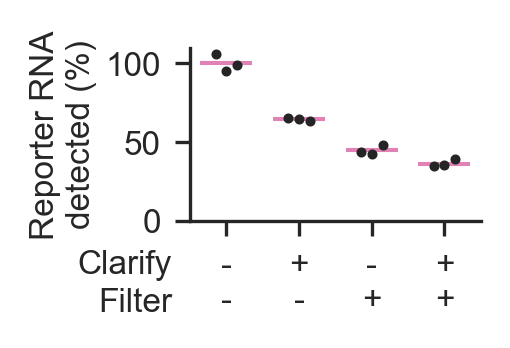

In [18]:
# Make simple swarm plot

field = "RNA molecules relative to reference %"

fig, ax = plt.subplots(1, 1, figsize=(1.25,0.75))

# Set axis scaling - must be done first so swarm plot dots do not overlap
ax.set_ylim(0, 110)

# Plot summary

y = summary_subset[field]
x = np.arange(len(y))

sns.scatterplot(ax=ax, x=x, y=y, marker="_", s=150, color="#e082b5")

# Plot individual points as swarm (sort columns appropriately)

sample_to_rank = dict(zip(index_ordered, range(len(index_ordered))))
data["rank"] = [sample_to_rank[s] for s in data["Sample"]]
data = data.sort_values(by="rank")

y_swarm = data[field]
x_swarm = np.array([x[rank] for rank in data["rank"]])

x_offset = np.array([-0.15, 0, 0.15])  # jitter offsets to avoid operlaps
x_swarm_offset = x_swarm + np.tile(x_offset, int(len(x_swarm)/len(x_offset)))

ax.scatter(x_swarm_offset, y_swarm, color="#252525", s=2, zorder=10)

ax.set_xlim(min(x)-0.5, max(x)+0.5)

ax.set_ylabel("Reporter RNA\ndetected (%)", labelpad=2)

ax.set_yticks([0, 50, 100])

ax.set_xticks([0, 1, 2, 3])
xticklabels = ["-\n-", "+\n-", "-\n+", "+\n+"]
ax.set_xticklabels(xticklabels)

ax.text(-0.75, -18, "Clarify", ha="right", va="top", size=FONTSIZE)
ax.text(-0.75, -42, "Filter", ha="right", va="top", size=FONTSIZE)

ax.set_xlabel("")

sns.despine()

save_figure(fig, "clarify_filter_GagMCP")